In [3]:
## Import necessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import copy
import math

%matplotlib inline

In the following cells I load the dataset and make some key changes to it. Access to this data set is free and found at https://data.scorenetwork.org/football/nfl-team-statistics.html

Firstly, I filtered to only inclue teams in the 2020 season or after. In 2020, the NFL expanded the playoffs from 12 teams to 14 teams. Therefore using data from prior to 2020 would underestimate playoff chances.

Next I filtered to only use relevent stats for my model. I want my model to be based on two features: offensive epa per play and defensive epa per play. The dataset I am using contains rushing epa per play, passing epa per play, total rushing epa, and total passing epa. Therefore to find the average epa per play of both rushing and passing, I find and add the total offensive plays, and divide that by the total offensive epa. 

In [4]:


# Load training dataset
file_path = "C:\\Users\\colin\\Downloads\\nfl-team-statistics.xlsx"
df = pd.read_excel(file_path)

# In 2020, the NFL expanded the playoffs from 12 teams to 14 teams. Therefore using data from prior to 2020 would underestimate playoff chances
# Filter dataset to only include year > 2020
df = df[(df['season'] >= 2020)]

# Filter to use relevent features (total/average offensive epa pass/run and total/average defensive epa pass/run)
df = df.iloc[:, [0,1,16,17,18,19,40,41,42,43,52]]

print('DataFrame shape: ' + str(df.shape))
df.head(4)

DataFrame shape: (96, 11)


,season,team,offense_total_epa_pass,offense_total_epa_run,offense_ave_epa_pass,offense_ave_epa_run,defense_total_epa_pass,defense_total_epa_run,defense_ave_epa_pass,defense_ave_epa_run,wins
669,2020,ARI,7.007549,33.798589,0.011718,0.071912,12.910698,-5.786441,0.020925,-0.013457,8
670,2020,ATL,59.668701,-37.520450,0.088925,-0.094272,95.684520,-31.665034,0.146981,-0.085813,4
671,2020,BAL,38.708894,78.713823,0.088782,0.144961,-24.482173,-36.210490,-0.038555,-0.095291,11
672,2020,BUF,167.767670,-2.490299,0.268858,-0.006502,6.657568,10.833549,0.010861,0.026231,13


In [7]:
# Create new columns used to calculate average epa per play
df['total_off_plays'] = df['offense_total_epa_pass']/df['offense_ave_epa_pass'] + df['offense_total_epa_run']/df['offense_ave_epa_run']
df['total_def_plays'] = df['defense_total_epa_pass']/df['defense_ave_epa_pass'] + df['defense_total_epa_run']/df['defense_ave_epa_run']
df['total_off_epa'] = df['offense_total_epa_pass'] + df['offense_total_epa_run']
df['total_def_epa'] = df['defense_total_epa_pass'] + df['defense_total_epa_run']
df['off_epa_per_play'] = df['total_off_epa'] / df['total_off_plays']
df['def_epa_per_play'] = df['total_def_epa'] / df['total_def_plays']

Now I have my input training set (offensive and defensive epa), I need my output training set(playoff status). Unfortunately, playoff status is not in this data set. Therefore, I created a playoff status column and initially set it to zero (non-playoff team). Over this span of years, mostly all ten or more win teams made it to the playoffs. Therefore, if wins >=10, I set playoff status to zero, and manually changed any 9 win teams which made it or 10 win teams which didn't. 

In [9]:
df['playoff_status'] = 0
df['playoff_status'] = np.where(df['wins'] > 9, 1, 0)
df.loc[(df['team'] == 'MIA') & (df['season'] == 2020), 'playoff_status'] = 0
df.loc[(df['team'] == 'CHI') & (df['season'] == 2020), 'playoff_status'] = 1
df.loc[(df['team'] == 'WAS') & (df['season'] == 2020), 'playoff_status'] = 1
df.loc[(df['team'] == 'PHI') & (df['season'] == 2021), 'playoff_status'] = 1
df.loc[(df['team'] == 'PIT') & (df['season'] == 2021), 'playoff_status'] = 1
df.loc[(df['team'] == 'TAM') & (df['season'] == 2022), 'playoff_status'] = 1
df.loc[(df['team'] == 'NYG') & (df['season'] == 2022), 'playoff_status'] = 1
df.loc[(df['team'] == 'SEA') & (df['season'] == 2022), 'playoff_status'] = 1
df.loc[(df['team'] == 'JAG') & (df['season'] == 2022), 'playoff_status'] = 1
df.loc[(df['team'] == 'MIA') & (df['season'] == 2022), 'playoff_status'] = 1

df.head(4)

,season,team,offense_total_epa_pass,offense_total_epa_run,offense_ave_epa_pass,offense_ave_epa_run,defense_total_epa_pass,defense_total_epa_run,defense_ave_epa_pass,defense_ave_epa_run,wins,total_off_plays,total_def_plays,total_off_epa,total_def_epa,off_epa_per_play,def_epa_per_play,playoff_status
669,2020,ARI,7.007549,33.798589,0.011718,0.071912,12.910698,-5.786441,0.020925,-0.013457,8,1068.0,1047.0,40.806139,7.124258,0.038208,0.006804,0
670,2020,ATL,59.668701,-37.520450,0.088925,-0.094272,95.684520,-31.665034,0.146981,-0.085813,4,1069.0,1020.0,22.148251,64.019486,0.020719,0.062764,0
671,2020,BAL,38.708894,78.713823,0.088782,0.144961,-24.482173,-36.210490,-0.038555,-0.095291,11,979.0,1015.0,117.422717,-60.692663,0.119941,-0.059796,1
672,2020,BUF,167.767670,-2.490299,0.268858,-0.006502,6.657568,10.833549,0.010861,0.026231,13,1007.0,1026.0,165.277371,17.491118,0.164128,0.017048,1


In [43]:
X_train = df[['off_epa_per_play','def_epa_per_play']]
y_train = df[['playoff_status']]

In [45]:
print ('The shape of X_train is: ' + str(X_train.shape))
print ('The shape of y_train is: ' + str(y_train.shape))
print ('We have m = %d training examples' % (len(y_train)))


The shape of X_train is: (96, 2)
The shape of y_train is: (96, 1)
We have m = 96 training examples


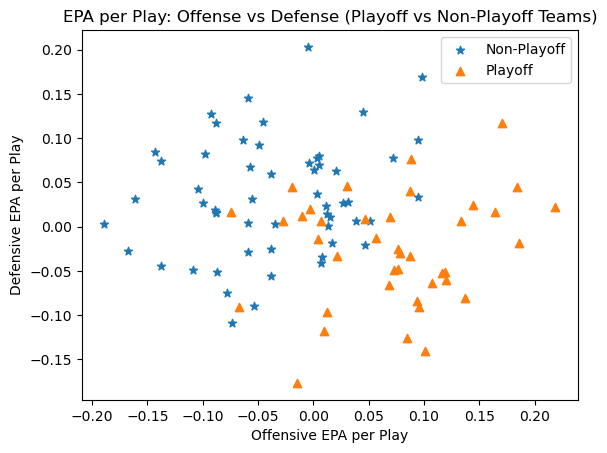

In [47]:
playoff = df[df['playoff_status'] == 1]
non_playoff = df[df['playoff_status'] == 0]
plt.scatter(non_playoff['off_epa_per_play'], non_playoff['def_epa_per_play'],
            label='Non-Playoff', marker='*')
plt.scatter(playoff['off_epa_per_play'], playoff['def_epa_per_play'],
            label='Playoff', marker='^')
plt.xlabel('Offensive EPA per Play')
plt.ylabel('Defensive EPA per Play')
plt.title('EPA per Play: Offense vs Defense (Playoff vs Non-Playoff Teams)')
plt.legend()
plt.show()

Note that a good Offensive team has a positive Epa, and a good defensive team has a negative epa. Keeping this in mind, we can see a clear trend as playoff teams are much more concentrated on the lower right quadrant of the graph. 

Now I will create my model for Logistic regression. To do this, I need the Sigmoid function, Cost function, and Gradient Descent Function for Linear Regression. The following methods calculate each

In [49]:
def sigmoid(z):
    
    return 1 / (1 + np.exp(-z))  
    
    return g

In [51]:
# Method computing cost function

def compute_cost(X, y, w, b):
    # X = offensive and defensive epa 
    # y = playoff status 
    # w = values of parameters for model 
    # b = value of bias parameter 
    # m = number of training examples 
    # n = number features
    m, n = X.shape
    # z = fw,b(x[i]) or the models prediction
    z = np.dot(X, w) + b
    total_cost = 0

    eps = 1e-15
    # for loop which iterates through each training example, computes the loss function value and adds to total cost
    for i in range(m):
        s = sigmoid(z[i])
        s = min(max(s, eps), 1 - eps)
        loss = -y[i] * math.log(s) - (1 - y[i]) * math.log(1 - s)
        total_cost += loss

    return total_cost / m



In [53]:
# Method computing Gradient function
def compute_gradient(X, y, w, b): 
    m, n = X.shape
    dj_dw = np.zeros(w.shape)
    dj_db = 0
    y = np.squeeze(y)
    
    z = np.dot(X,w)+b
    # for loop which iterates through each training example
    for i in range(m):
        # compute derivative of cost function relating to b at i and add to dj_db
        dj_db = dj_db + (sigmoid(z[i])-y[i])
        # nested for loop which iterates for each training example and each feature. 
        for j in range(n): 
            # compute derivative of cost function relating to w at i,j and add to dj_dw
            dj_dw[j] = dj_dw[j] + (sigmoid(z[i])-y[i])*X[i,j]
    dj_dw = dj_dw/m
    dj_db = dj_db/m
    
    return dj_dw, dj_db

In [55]:
def gradient_descent(X, y, w, b, cost_function, gradient_function, alpha, num_iters): 
    
    X = np.array(X)
    y = np.squeeze(np.array(y))   # ensure shape (m,)
    
    J_history = []
    w_history = []

    for i in range(num_iters):

        # Compute gradients
        dj_dw, dj_db = gradient_function(X, y, w, b)

        # Update parameters
        w = w - alpha * dj_dw
        b = b - alpha * dj_db

        # Track cost
        cost = cost_function(X, y, w, b)
        J_history.append(cost)

        # Save parameter history
        if i % math.ceil(num_iters / 10) == 0 or i == num_iters - 1:
            w_history.append(w.copy())   # <-- important fix
            print(f"Iteration {i:4}: Cost {cost:8.2f}")

    return w, b, J_history, w_history


In [59]:
np.random.seed(1)
initial_w = np.array([2,-1])
initial_b = -.3

# Some gradient descent settings
iterations = 15000
alpha = 0.001

w,b, J_history,w_history = gradient_descent(X_train ,y_train, initial_w, initial_b, 
                                   compute_cost, compute_gradient, alpha, iterations)
print(w)
print(b)

Iteration    0: Cost     0.62
Iteration 1500: Cost     0.62
Iteration 3000: Cost     0.62
Iteration 4500: Cost     0.61
Iteration 6000: Cost     0.61
Iteration 7500: Cost     0.61
Iteration 9000: Cost     0.61
Iteration 10500: Cost     0.61
Iteration 12000: Cost     0.61
Iteration 13500: Cost     0.61
Iteration 14999: Cost     0.61
[ 2.32682464 -1.19280473]
-0.3495968593024334


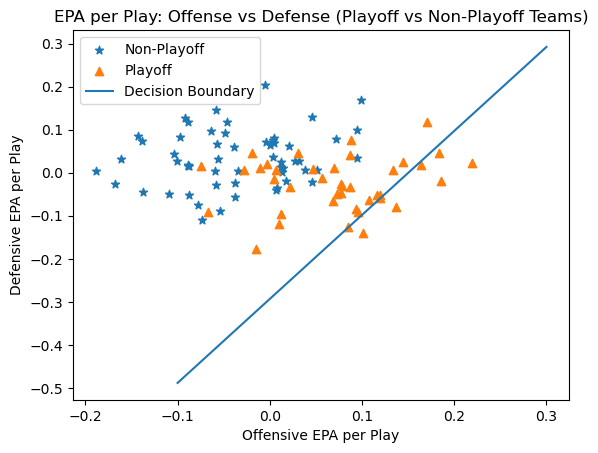

In [95]:
x1 = np.linspace(-.1, .3, 100)  
x2 = -(w[0]/w[1])*x1 - b/w[1]

plt.scatter(non_playoff['off_epa_per_play'], non_playoff['def_epa_per_play'],
            label='Non-Playoff', marker='*')
plt.scatter(playoff['off_epa_per_play'], playoff['def_epa_per_play'],
            label='Playoff', marker='^')
plt.plot(x1, x2, label='Decision Boundary')
plt.xlabel('Offensive EPA per Play')
plt.ylabel('Defensive EPA per Play')
plt.title('EPA per Play: Offense vs Defense (Playoff vs Non-Playoff Teams)')
plt.legend()
plt.show()

There we have our predicted parameters, intercept, and decision boundary. Based off of a glance, we can see the line underfits the data- likely due to lack of training examples and features. 

Next I want to see how the model predicts the training data and test its accuracy. 

In [69]:
z = np.dot(X_train,w) + b

In [71]:
y_prob = sigmoid(z)
y_pred = (y_prob >= 0.5).astype(int)
print(y_pred)

[0 0 1 1 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [79]:
y_train = np.array(y_train)

In [81]:
acc = np.mean(y_pred == y_train)
print("Training accuracy:", acc)

Training accuracy: 0.5711805555555556


A training accuracy of 57% is not great. All of the model's misses come when it predicts playoff teams not making it. 

Nevertheless, lets see how the model predicts the 2025 NFL. Using data from Sumersports, I manually entered each teams offensive and defensive epa per play as of week 14.  

In [83]:
# NFL team statistics as of wk14
nfl_2025 = {'team': ['Eagles', 'Giants', 'Cowboys', 'Commanders', 'Lions', 'Packers', 'Bears', 'Vikings', 'Falcons', 'Buccaneers', 'Saints', 'Panthers',
                     'Rams', '49ers', 'Cardinals', 'Seahawks', 'Patriots', 'Bills', 'Dolphins', 'Jets', 'Ravens', 'Steelers', 'Browns', 'Bengals', 
                     'Colts', 'Texans', 'Jaguars', 'Titans', 'Chiefs', 'Chargers', 'Broncos', 'Raiders'],
        'off_epa_per_play': [-0.01, 0, 0.09, 0, 0.1, 0.14, 0.06, -0.14, -0.05, -0.03, -0.13, -0.03, 0.11, 0.04, -0.02, 0.03, 0.09, 0.13, 0, -0.1, -0.02,
                             0, -0.18, -0.04, 0.12, -0.01, -0.01, -0.19, 0.1, -0.03, 0.05, -0.19],
        'def_epa_per_play': [-0.07, 0.12, 0.14, 0.14, -0.03, -0.01, 0.01, -0.07, 0, -0.02, -0.04, 0.07, -0.1, 0.04, 0.03, -0.12, -0.05, 0, 0.04, 0.09,
                             0.02, 0.02, -0.11, 0.15, -0.03, -0.15, -0.09, 0.07, -0.01, -0.08, -0.08, 0.02]}
nfl_2025 = pd.DataFrame(nfl_2025)


In [85]:
X_test = nfl_2025[['off_epa_per_play','def_epa_per_play']]


In [89]:
z_test = np.dot(X_test,w) + b

In [91]:
y_prob_test = sigmoid(z_test)
y_pred_test = (y_prob_test >= 0.5).astype(int)
print(y_pred_test)

[0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


Based on the model, the one and only team predicted to make the playoffs, as of week 14 of the 2025 season, are the Rams. Of course, this is a big underestimation, as 14 teams make the playoffs. It is clear the model is far too conservative when predicting playoffs. 
Some things that could improve the model:
More training data
More features such as strength of schedule, turnover margin, and divisional strength

